In [128]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [129]:
# Test URLs and requests with 1 or 2 URLs...

url_1 = 'https://www.pro-football-reference.com/players/J/JackLa00.htm'
url_2 = 'https://www.pro-football-reference.com/players/W/WarnKu00.htm'
url_3 = 'https://www.pro-football-reference.com/players/B/BartSt00.htm'
# GET request to the URL
response = requests.get(url_1)
tables = {}
# Check if the request was successful
if response.status_code == 200:
    # Parse HTML content with BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')
    # Find all tables in the HTML content, print the number found.
    tables = soup.find_all('table')
    print(f"Number of tables found: {len(tables)}")

    # Iterate over all tables and print a snippet to identify the correct one
    for i, table in enumerate(tables):
        print(f"\nTable {i}:")
        print(table.prettify()[:1000])  # Print snippet of table
else:
    print(f"Failed to fetch the webpage. Status code: {response.status_code}")



Number of tables found: 15

Table 0:
<table class="sortable stats_table" data-cols-to-freeze=",1" id="last5">
 <caption>
  2024 Game Logs Table
 </caption>
 <colgroup>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
 </colgroup>
 <thead>
  <tr class="over_header">
   <th aria-label="" class="over_header center" colspan="5" data-stat="">
   </th>
   <th aria-label="" class="over_header center" colspan="18" data-stat="header_pass">
    Passing
   </th>
   <th aria-label="" class="over_header center" colspan="5" data-stat="header_rush">
    Rushing
   </th>
   <th>
   </th>
  </tr>
  <tr>
   <th aria-label="Date" class="poptip center" data-stat="date" scope="col">
    Date
   </th>
   <th aria-label="Team" class="poptip center" data-stat="team_name_abbr" scope="col">
    Team
   

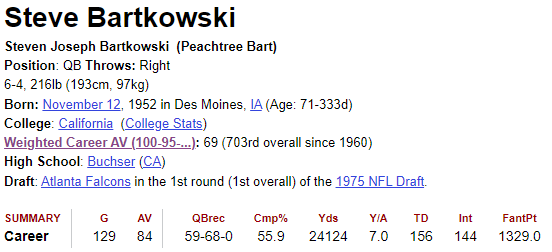




### Data Summary

div id="info" class="players" holds all data, then the following sections:

1.  div id = "meta"    
The players meta data can be found here:  <example data for this URL>
name <Steve Bartkowski>, nickname <Peachtree Bart>, Throws <Right>
height <6-4>, weight  <216lb>, born_date <1952-11-12> or after the birthdays.cgi: <November 12, 1952>
born_location <Des Moines, IA>, college <California>, highschool  <>, draft  <>

2. after div#meta closes, new section, with id="bling"
li class="all_star", Href for: probowl, awards
'Recognition' header: all_star; 'Uniforms' data header: uniforms

3.  the final section follows span with a strong SUMMARY header.  Would like the following data as variables pulled out here:
G, AV, QBrec, Cmp%, Yds, Y/A, TD, Int, FantPt

In [130]:
def get_recognition(soup):
    recognition_data = {}
    try:
        bling = soup.find('ul', id='bling')
        recognition_data['all_star'] = [li.get_text(strip=True) for li in bling.find_all('li', class_='all_star')]
        recognition_data['uniforms'] = [a['data-tip'] for a in soup.find('div', class_='uni_holder').find_all('a')]
    except AttributeError:
        recognition_data = {key: "N/A" for key in ['all_star', 'uniforms']}
    return recognition_data

def get_summary_stats(soup):
    summary_stats = {}
    try:
        summary = soup.find('div', {'class': 'stats_pullout'})
        summary_stats['games_played'] = summary.find('span', string='G').find_next('p').text.strip()
        summary_stats['approximate_value'] = summary.find('span', string='AV').find_next('p').text.strip()
        summary_stats['qb_record'] = summary.find('span', string='QBrec').find_next('p').text.strip()
        summary_stats['completion_percentage'] = summary.find('span', string='Cmp%').find_next('p').text.strip()
        summary_stats['passing_yards'] = summary.find('span', string='Yds').find_next('p').text.strip()
        summary_stats['yards_per_attempt'] = summary.find('span', string='Y/A').find_next('p').text.strip()
        summary_stats['touchdowns'] = summary.find('span', string='TD').find_next('p').text.strip()
        summary_stats['interceptions'] = summary.find('span', string='Int').find_next('p').text.strip()
        summary_stats['fantasy_points'] = summary.find('span', string='FantPt').find_next('p').text.strip()
    except AttributeError:
        summary_stats = {key: "N/A" for key in ['games_played', 'approximate_value', 'qb_record', 'completion_percentage', 'passing_yards', 'yards_per_attempt', 'touchdowns', 'interceptions', 'fantasy_points']}
    return summary_stats

In [131]:
import re

def get_faq(soup):
    faq_data = {}
    keyword_patterns = {
        'when_born': re.compile(r'when.*born', re.IGNORECASE),
        'where_born': re.compile(r'where.*born', re.IGNORECASE),
        'height': re.compile(r'tall', re.IGNORECASE),
        'weight': re.compile(r'weigh', re.IGNORECASE),
        'games_played': re.compile(r'games.*play', re.IGNORECASE),
        'pass_yards': re.compile(r'passing.*yards', re.IGNORECASE),
        'TD': re.compile(r'touchdowns', re.IGNORECASE),
        'superbowls': re.compile(r'Super Bowls', re.IGNORECASE),
        'retire_year': re.compile(r'retire', re.IGNORECASE),
        'nickname': re.compile(r'nicknames', re.IGNORECASE)
    }

    try:
        faq = soup.find('div', id='div_faq')
        for key, pattern in keyword_patterns.items():
            question = faq.find('h3', string=pattern)
            if question:
                answer = question.find_next('p').text
                if key in ['when_born', 'where_born']:
                    faq_data[key] = re.split(r'on | in ', answer)[-1].strip('.')
                elif key == 'height':
                    faq_data[key] = re.search(r'\d+-\d+', answer).group()
                elif key == 'weight':
                    faq_data[key] = re.search(r'\d+ lbs', answer).group().split()[0]
                elif key == 'superbowls':
                    faq_data[key] = re.search(r'\d+', answer) and re.search(r'\d+', answer).group() or '0'
                elif key in ['games_played', 'pass_yards', 'TD']:
                    faq_data[key] = re.search(r'\d+', answer.replace(',', '')).group()
                elif key == 'retire_year':
                    faq_data[key] = re.search(r'\d+', answer).group()
                elif key == 'nickname':
                    faq_data[key] = re.split(r' is a nickname| are nicknames', answer)[0]
                else:
                    faq_data[key] = answer
    except AttributeError as e:
        print(f"An error occurred: {e}")
    return faq_data

In [132]:
import re

def get_qb_header_data(soup):
    qb_header_data = {
        'throws': '', 'hall_of_fame': '', 'college': '', 'high_school': '',
        'weighted_career_av': '', 'college_stats': '', 'draft_team': '',
        'draft_round': '', 'draft_pick': '', 'draft_year': ''    }

    try:
        # Extract Throws
        throws_tag = soup.find('strong', string='Throws:')
        if throws_tag and throws_tag.next_sibling:
            qb_header_data['throws'] = throws_tag.next_sibling.strip()

        # Extract College
        college_tag = soup.find('strong', text='College')
        if college_tag:
            college = college_tag.find_next('a')
            if college:
                qb_header_data['college'] = college.text.strip()

        # Extract College Stats URL
        college_stats_tag = soup.find('a', href=re.compile(r'https://www.sports-reference.com/cfb/players/'))
        if college_stats_tag:
            qb_header_data['college_stats'] = college_stats_tag['href']

        # Extract Weighted Career AV (wAV)
        wav_tag = re.search(r'Weighted Career AV.*?(\d+)', str(soup))
        if wav_tag:
            qb_header_data['weighted_career_av'] = wav_tag.group(1)

        # Extract High School
        high_school_tag = soup.find('strong', text='High School')
        if high_school_tag:
            high_school = high_school_tag.find_next('a')
            if high_school:
                qb_header_data['high_school'] = high_school.text.strip()

        # Extract Hall of Fame year (hof)
        hof_tag = re.search(r'Hall of Fame.*?(\d{4})', str(soup))
        if hof_tag:
            qb_header_data['hall_of_fame'] = hof_tag.group(1)

        # Extract Draft Team, Round, Pick, and Year
        draft_team_tag = re.search(r'Draft.*?<a.*?>(.*?)</a>', str(soup))
        if draft_team_tag:
            qb_header_data['draft_team'] = draft_team_tag.group(1)

        draft_round_tag = re.search(r'in the (\d+)(?:st|nd|rd|th) round', str(soup))
        if draft_round_tag:
            qb_header_data['draft_round'] = draft_round_tag.group(1)

        draft_pick_tag = re.search(r'\((\d+)(?:st|nd|rd|th) overall\)', str(soup))
        if draft_pick_tag:
            qb_header_data['draft_pick'] = draft_pick_tag.group(1)

        draft_year_tag = re.search(r'(\d{4}) NFL Draft', str(soup))
        if draft_year_tag:
            qb_header_data['draft_year'] = draft_year_tag.group(1)

    except AttributeError as e:
        print(f"An error occurred: {e}")

    return qb_header_data

In [159]:
import requests
from bs4 import BeautifulSoup

def get_soup(url):
    response = requests.get(url)
    if response.status_code == 200:
        return BeautifulSoup(response.content, 'html.parser')
    else:
        print(f"Failed to retrieve webpage. Status code: {response.status_code}")
        return None

url = "https://www.pro-football-reference.com/players/M/MannPe00.htm"

soup = get_soup(url)
if soup:
    qb_header_data = get_qb_header_data(soup)
    summary_stats = get_summary_stats(soup)
    recognition_data = get_recognition(soup)
    faq_data = get_faq(soup)
    print("")
    print("qb_header_data:", qb_header_data)
    print("Summary Stats:", summary_stats)
    print("Recognition:", recognition_data)
    print("FAQ Data:", faq_data)
    print("")
else: 
    print('no soup for you.')

import pprint
# Create a PrettyPrinter instance
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(qb_header_data)

C:\Users\black\AppData\Local\Temp\ipykernel_18864\4017800806.py:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  college_tag = soup.find('strong', text='College')
C:\Users\black\AppData\Local\Temp\ipykernel_18864\4017800806.py:33: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  high_school_tag = soup.find('strong', text='High School')



qb_header_data: {'throws': 'Right', 'hall_of_fame': '2000', 'college': 'Tennessee', 'high_school': 'Isidore Newman', 'weighted_career_av': '100', 'college_stats': 'https://www.sports-reference.com/cfb/players/peyton-manning-1.html', 'draft_team': 'Indianapolis Colts', 'draft_round': '1', 'draft_pick': '1', 'draft_year': '1998'}
Summary Stats: {'games_played': '266', 'approximate_value': '271', 'qb_record': '186-79-0', 'completion_percentage': '65.3', 'passing_yards': '71940', 'yards_per_attempt': '7.7', 'touchdowns': '539', 'interceptions': '251', 'fantasy_points': '4686.3'}
Recognition: {'all_star': ['14x Pro Bowl', '7x All-Pro'], 'uniforms': ['Indianapolis Colts 1998-2010', 'Denver Broncos 2012-2015']}
FAQ Data: {'when_born': 'March 24, 1976', 'where_born': 'New Orleans, LA', 'height': '6-5', 'weight': '230', 'games_played': '266', 'pass_yards': '71940', 'TD': '539', 'superbowls': '2', 'retire_year': '2015', 'nickname': 'The Sheriff, The Caveman, Peydirt'}

{   'college': 'Tennessee

In [160]:
# TESTING 

# Testing with a couple of URLs

import pprint
url = "https://www.pro-football-reference.com/players/B/BartSt00.htm"
url2 = "https://www.pro-football-reference.com/players/W/WarnKu00.htm"


soup = get_soup(url)
if soup:
    qb_header_data = get_qb_header_data(soup)#copilot
else: 
    print('no soup for you.')  

print(f"\nurl1  {url}")
# Create a PrettyPrinter instance
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(qb_header_data)

soup = get_soup(url2)
if soup:
    qb_header_data = get_qb_header_data(soup)
else: 
    print('no soup for you.')  

print(f"\nurl2  {url2}")
pp = pprint.PrettyPrinter(indent=4)
print("\nver 1")
pp.pprint(qb_header_data)

C:\Users\black\AppData\Local\Temp\ipykernel_18864\4017800806.py:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  college_tag = soup.find('strong', text='College')
C:\Users\black\AppData\Local\Temp\ipykernel_18864\4017800806.py:33: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  high_school_tag = soup.find('strong', text='High School')



url1  https://www.pro-football-reference.com/players/B/BartSt00.htm
{   'college': 'California',
    'college_stats': 'https://www.sports-reference.com/cfb/players/steve-bartkowski-1.html',
    'draft_pick': '1',
    'draft_round': '1',
    'draft_team': 'Atlanta Falcons',
    'draft_year': '1975',
    'hall_of_fame': '8842',
    'high_school': 'Buchser',
    'throws': 'Right',
    'weighted_career_av': '100'}

url2  https://www.pro-football-reference.com/players/W/WarnKu00.htm

ver 1
{   'college': 'Northern Iowa',
    'college_stats': '',
    'draft_pick': '',
    'draft_round': '',
    'draft_team': 'Draft History',
    'draft_year': '',
    'hall_of_fame': '1999',
    'high_school': 'Regis',
    'throws': 'Right',
    'weighted_career_av': '100'}


In [161]:
# Sample URL for a player page : Kurt Warner, https://www.pro-football-reference.com/players/W/WarnKu00.htm

base_url = "https://www.pro-football-reference.com/players/"
suffix_url = "00.htm"

def create_url(name):
    '''function to build the following url from the name passed in:
    name_link=  <first letter of last name> / <first four letters of last name><first two letters of first name>
    eg.  Kurt Warner --> W/WarnKu'''

    try:
        # Remove apostrophes from the name
        name = name.replace("'", "")
        
        # Split the name into parts
        name_parts = name.split()

        # Ensure there are at least two parts (first name and last name)
        if len(name_parts) < 2:
            raise ValueError("Name must contain at least a first and last name")

        # The first part is the first name, and the last part is the last name
        first_name = name_parts[0]
        
        # Combine all parts of the last name (if there are multiple parts)
        last_name = ''.join(name_parts[1:])

        # The directory is based on the first letter of the last name
        directory_letter = last_name[0].upper()

        # Ensure the last name has at least 4 characters to avoid index errors
        if len(last_name) < 4:
            raise ValueError("Last name must have at least 4 characters for URL creation")

        # Create the name link using the first four letters of the last name and the first two letters of the first name
        name_link = f"{last_name[:4]}{first_name[:2]}"

        # Build the final URL
        url = f"https://www.pro-football-reference.com/players/{directory_letter}/{name_link}00.htm"

        return url

    except (IndexError, ValueError) as e:
        # In case of any error, return a placeholder or error message
        print(f"Error generating URL for '{name}': {e}")
        return "https://www.pro-football-reference.com/players/Unknown/Unknown00.htm"

name_list = ["Steve Deberg",      # Expected: players/D/DebeSt00.htm
                "Norman Van Broklin",  # Expected: VanBroNo
                "Kurt Warner",         # Expected: WarnKu
                "Ken O'Brien",     # Expected: players/O/OBriKe00.htm
                "John Smith"]           # Expected: SmitJo 

for name in name_list: 
    print(create_url(name))



https://www.pro-football-reference.com/players/D/DebeSt00.htm
https://www.pro-football-reference.com/players/V/VanBNo00.htm
https://www.pro-football-reference.com/players/W/WarnKu00.htm
https://www.pro-football-reference.com/players/O/OBriKe00.htm
https://www.pro-football-reference.com/players/S/SmitJo00.htm


### Bring in nfl_career_statistics.csv  to get QB names, etc.

In [162]:
# get lists of QBs to get data for:
rel_path = "../Data_Artifacts/nfl_career_statistics.csv"
qb_name_df = pd.read_csv(rel_path)
print(len(qb_name_df))

qb_name_df.head()

# import os
# absolute_path = os.path.abspath(rel_path)
# print(f"Absolute path: {absolute_path}")

# # Check if the file exists and open it with the default application
# if os.path.exists(absolute_path):
#     os.startfile(absolute_path)
#     print('Opened with default application.')
# else:
#     print(f'File not found at: {absolute_path}')

637


,player,drafted,yrs_played,teams,hof,wAV,earnings_mils,comp_%,pass_rating,comp,att,pass_yds,TD,pass_yds_game,int,int_%,pick_6,sacks,4QC,GWD
0,Tom Brady,2000.0,23.0,"['Patriots', 'Buccaneers']",0.0,184.0,317.620,64.3,97.2,7753.0,12050.0,89214.0,649.0,266.0,212.0,1.8,18.0,565.0,46.0,58.0
1,Drew Brees,2001.0,20.0,"['Saints', 'Chargers']",0.0,167.0,273.933,67.7,98.7,7142.0,10551.0,80358.0,571.0,280.0,243.0,2.3,27.0,420.0,36.0,53.0
2,Peyton Manning,1998.0,18.0,"['Colts', 'Broncos']",1.0,176.0,247.714,65.3,96.5,6125.0,9380.0,71940.0,539.0,270.0,251.0,2.7,27.0,303.0,43.0,54.0
3,Brett Favre,1991.0,20.0,"['Packers', 'Vikings', 'Jets', 'Falcons']",1.0,158.0,141.407,62.0,86.0,6300.0,10169.0,71838.0,508.0,237.0,336.0,3.3,32.0,525.0,28.0,43.0
4,Ben Roethlisberger,2004.0,18.0,['Steelers'],0.0,131.0,266.724,64.4,93.5,5440.0,8443.0,64088.0,418.0,257.0,211.0,2.5,18.0,554.0,41.0,53.0


### GET values from 4 dictionaries (qb_header_data, summary_stats, recognition_data, faq_data), 
based on different sections of the webpage.  
Merge these 4 dictionaries of data into single nested dictionary, 
with values flattened under one key (player's name) (not as sub-dictionaries).

### LOOP tahrough each entry and make an entry in the quarterback_dict

In [164]:

#  merge Values from 4 dictionaries (qb_header_data, summary_stats, recognition_data, faq_data) into single nested dictionary, 
#  with values flattened under one key (player's name).  (Not as sub-dictionaries).
                                      
# loop through each name, get the values from the sub-dictionaries, and populate 
# an entry in the quarterback_dict with their entry 

import time
# Currently we will block users sending requests to: (locked out up to a day.)
#   FBref/Stathead sites > 10 requests/minute (need wait time of over 6 seconds)
#   Other sites > 20 req/min. (need wait time longer than 3 seconds)
# Regardless of bot type/construction/pages accessed.

# qb_list = ['Steven Bartkowski', 'Tom Brady', 'Drew Brees', 'Peyton Manning', 
#           'Brett Favre', 'Steve Deberg', 'Norman Van Broklin', 'Kurt Warner', "Ken O'Brien",  'John Smith']
quarterback_dict = {}
quarterback_fails = []
qb_list = qb_name_df['player'].tolist()
print(len(qb_list))

# Combine data from each dictionary into a single player_data dictionary
def merge_player_data_dicts(name):
    player_data = {}

    player_data.update(qb_header_data)       # Add QB header data
    player_data.update(summary_stats)         # Add summary stats
    player_data.update(recognition_data)      # Add recognition data
    player_data.update(faq_data)              # Add FAQ data

    # Store the player_data dictionary in the quarterback_dict, with player's name as key
    quarterback_dict[name] = player_data

for idx, name in enumerate(qb_list)    # qb_list
    print(f'player ({idx}) :  {name}')
    time.sleep(8)
    soup = get_soup(create_url(name))
    if soup:
        qb_header_data = get_qb_header_data(soup)
        summary_stats = get_summary_stats(soup)
        recognition_data = get_recognition(soup)
        faq_data = get_faq(soup)
        print("qb_header_data:", qb_header_data)
        print("Summary Stats:", summary_stats)
        print("Recognition:", recognition_data)
        print("FAQ Data:", faq_data)
        print("")
        merge_player_data_dicts(name)
    else: 
        quarterback_fails.append(name)     
        print(f'no soup for you, {name}')  
        print("")


# output is the quarterback_dict, where a ton of variables for each Quarterback
#   are accessed with the Quarterback name as the key.

637
player (85) :  Steve Bartkowski


C:\Users\black\AppData\Local\Temp\ipykernel_18864\4017800806.py:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  college_tag = soup.find('strong', text='College')
C:\Users\black\AppData\Local\Temp\ipykernel_18864\4017800806.py:33: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  high_school_tag = soup.find('strong', text='High School')


qb_header_data: {'throws': 'Right', 'hall_of_fame': '8842', 'college': 'California', 'high_school': 'Buchser', 'weighted_career_av': '100', 'college_stats': 'https://www.sports-reference.com/cfb/players/steve-bartkowski-1.html', 'draft_team': 'Atlanta Falcons', 'draft_round': '1', 'draft_pick': '1', 'draft_year': '1975'}
Summary Stats: {'games_played': '129', 'approximate_value': '84', 'qb_record': '59-68-0', 'completion_percentage': '55.9', 'passing_yards': '24124', 'yards_per_attempt': '7.0', 'touchdowns': '156', 'interceptions': '144', 'fantasy_points': '1329.0'}
Recognition: {'all_star': ['2x Pro Bowl'], 'uniforms': ['Atlanta Falcons 1975-1985', 'Los Angeles Rams 1986']}
FAQ Data: {'when_born': 'November 12, 1952', 'where_born': 'Des Moines, IA', 'height': '6-4', 'weight': '216', 'games_played': '129', 'pass_yards': '24124', 'TD': '156', 'superbowls': '0', 'retire_year': '1986', 'nickname': 'Peachtree Bart'}

player (86) :  Steve Beuerlein
qb_header_data: {'throws': 'Right', 'hall_

In [178]:
# output is the quarterback_dict, where a ton of variables for each Quarterback
#   are accessed with the Quarterback name as the key.

# Example: 
college = quarterback_dict['A.J. Feeley']['college']
draft_year = quarterback_dict['A.J. Feeley']['draft_year']

print(college)     # Output: Oregon
print(draft_year)  # Output: 2001

import pprint
# Print the combined data for verification
print("\nquarterback_dict:")
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(quarterback_dict)

Oregon
2001

quarterback_dict:
{   'A.J. Feeley': {   'TD': '28',
                       'all_star': 'N/A',
                       'approximate_value': '8',
                       'college': 'Oregon',
                       'college_stats': 'https://www.sports-reference.com/cfb/players/aj-feeley-1.html',
                       'completion_percentage': '55.8',
                       'draft_pick': '155',
                       'draft_round': '5',
                       'draft_team': 'Philadelphia Eagles',
                       'draft_year': '2001',
                       'fantasy_points': '233.5',
                       'games_played': '28',
                       'hall_of_fame': '',
                       'height': '6-3',
                       'high_school': 'Ontario',
                       'interceptions': '31',
                       'pass_yards': '4618',
                       'passing_yards': '4618',
                       'qb_record': '8-10-0',
                       'retire_yea

In [182]:
# Put the nested Dictionary quaterback_dict into a DataFrame
# 1. Convert quarterback_dict to a list of dictionaries, where each dictionary is a row
# 2. For each name, put their row of data in.

data_list = []     # holds the dictionaries where each dictionary represents a player's data, with 'name' as the first key

for name, stats in quarterback_dict.items():
    print(f'{name} \n {stats}')
    player_row = {'name': name}
    player_row.update(stats)  # Add the stats to the player_row dictionary
    print(player_row)
    data_list.append(player_row)

pro_ref_individ_raw_df = pd.DataFrame(data_list)   # converts the list of dictionaries into a Pandas DataFrame
pro_ref_individ_raw_df.head()
# qbs_included = [f'{idx} - {x}' for idx, x in enumerate(quarterback_dict.keys())]
# display(qbs_included)      

Steve Bartkowski 
 {'throws': 'Right', 'hall_of_fame': '8842', 'college': 'California', 'high_school': 'Buchser', 'weighted_career_av': '100', 'college_stats': 'https://www.sports-reference.com/cfb/players/steve-bartkowski-1.html', 'draft_team': 'Atlanta Falcons', 'draft_round': '1', 'draft_pick': '1', 'draft_year': '1975', 'games_played': '129', 'approximate_value': '84', 'qb_record': '59-68-0', 'completion_percentage': '55.9', 'passing_yards': '24124', 'yards_per_attempt': '7.0', 'touchdowns': '156', 'interceptions': '144', 'fantasy_points': '1329.0', 'all_star': ['2x Pro Bowl'], 'uniforms': ['Atlanta Falcons 1975-1985', 'Los Angeles Rams 1986'], 'when_born': 'November 12, 1952', 'where_born': 'Des Moines, IA', 'height': '6-4', 'weight': '216', 'pass_yards': '24124', 'TD': '156', 'superbowls': '0', 'retire_year': '1986', 'nickname': 'Peachtree Bart'}
{'name': 'Steve Bartkowski', 'throws': 'Right', 'hall_of_fame': '8842', 'college': 'California', 'high_school': 'Buchser', 'weighted_ca

,name,throws,hall_of_fame,college,high_school,weighted_career_av,college_stats,draft_team,draft_round,draft_pick,...,uniforms,when_born,where_born,height,weight,pass_yards,TD,superbowls,retire_year,nickname
0,Steve Bartkowski,Right,8842,California,Buchser,100,https://www.sports-reference.com/cfb/players/s...,Atlanta Falcons,1,1,...,"[Atlanta Falcons 1975-1985, Los Angeles Rams 1...","November 12, 1952","Des Moines, IA",6-4,216,24124,156,0,1986,Peachtree Bart
1,Steve Beuerlein,Right,8842,Notre Dame,Servite,100,https://www.sports-reference.com/cfb/players/s...,Los Angeles Raiders,4,110,...,"[Los Angeles Raiders 1988-1989, Dallas Cowboys...","March 7, 1965","Los Angeles, CA",6-3,220,24046,147,1,2003,NaN
2,Archie Manning,Right,8842,Mississippi,Drew,100,https://www.sports-reference.com/cfb/players/a...,New Orleans Saints,1,2,...,"[New Orleans Saints 1971-1982, Houston Oilers ...","May 19, 1949","Cleveland, MS",6-3,212,23911,125,0,1984,NaN
3,Brian Sipe,Right,8842,Grossmont College (CA),Grossmont,100,,Cleveland Browns,13,330,...,[Cleveland Browns 1974-1983],"August 8, 1949","San Diego, CA",6-1,195,23713,154,0,1983,NaN
4,Andrew Luck,Right,8842,Stanford,Stratford,100,https://www.sports-reference.com/cfb/players/a...,Indianapolis Colts,1,1,...,[Indianapolis Colts 2012-2018],"September 12, 1989","Washington, DC",6-4,240,23671,171,0,2018,NaN


### PAUSE POINT: EXPORT CSV

In [183]:
# Export a csv of the dataframe: pro_ref_individ_raw.csv

#Export csv
rel_path = "../Data_Artifacts/pro_ref_individ_raw.csv"
pro_ref_individ_raw_df.to_csv(rel_path, index=False)

### RESUME POINT: IMPORT CSV

In [3]:
# Import CSV   pro_ref_individ_raw.csv
import pandas as pd


rel_path = "../Data_Artifacts/pro_ref_individ_raw.csv"
individ_df = pd.read_csv(rel_path)

display(individ_df.iloc[:,:10].head())
display(individ_df.iloc[:,10:20].head())
display(individ_df.iloc[:,20:].head())

,name,throws,hall_of_fame,college,high_school,weighted_career_av,college_stats,draft_team,draft_round,draft_pick
0,Steve Bartkowski,Right,8842.0,California,Buchser,100.0,https://www.sports-reference.com/cfb/players/s...,Atlanta Falcons,1.0,1.0
1,Steve Beuerlein,Right,8842.0,Notre Dame,Servite,100.0,https://www.sports-reference.com/cfb/players/s...,Los Angeles Raiders,4.0,110.0
2,Archie Manning,Right,8842.0,Mississippi,Drew,100.0,https://www.sports-reference.com/cfb/players/a...,New Orleans Saints,1.0,2.0
3,Brian Sipe,Right,8842.0,Grossmont College (CA),Grossmont,100.0,NaN,Cleveland Browns,13.0,330.0
4,Andrew Luck,Right,8842.0,Stanford,Stratford,100.0,https://www.sports-reference.com/cfb/players/a...,Indianapolis Colts,1.0,1.0


,draft_year,games_played,approximate_value,qb_record,completion_percentage,passing_yards,yards_per_attempt,touchdowns,interceptions,fantasy_points
0,1975.0,129.0,84,59-68-0,55.9,24124.0,7.0,156.0,144.0,1329.0
1,1987.0,147.0,85,47-55-0,56.9,24046.0,7.2,147.0,112.0,1333.7
2,1971.0,151.0,94,35-101-3,55.2,23911.0,6.6,125.0,173.0,1364.6
3,1972.0,125.0,87,57-55-0,56.5,23713.0,6.9,154.0,149.0,1347.6
4,2012.0,86.0,80,53-33-0,60.8,23671.0,7.2,171.0,83.0,1686.2


,all_star,uniforms,when_born,where_born,height,weight,pass_yards,TD,superbowls,retire_year,nickname
0,['2x Pro Bowl'],"['Atlanta Falcons 1975-1985', 'Los Angeles Ram...","November 12, 1952","Des Moines, IA",6-4,216.0,24124.0,156.0,0.0,1986.0,Peachtree Bart
1,['1x Pro Bowl'],"['Los Angeles Raiders 1988-1989', 'Dallas Cowb...","March 7, 1965","Los Angeles, CA",6-3,220.0,24046.0,147.0,1.0,2003.0,NaN
2,['2x Pro Bowl'],"['New Orleans Saints 1971-1982', 'Houston Oile...","May 19, 1949","Cleveland, MS",6-3,212.0,23911.0,125.0,0.0,1984.0,NaN
3,"['1x Pro Bowl', '1x All-Pro']",['Cleveland Browns 1974-1983'],"August 8, 1949","San Diego, CA",6-1,195.0,23713.0,154.0,0.0,1983.0,NaN
4,['4x Pro Bowl'],['Indianapolis Colts 2012-2018'],"September 12, 1989","Washington, DC",6-4,240.0,23671.0,171.0,0.0,2018.0,NaN


### NEW DATAFRAME

In [21]:
# Assuming individ_df is your DataFrame
cleaning_df = individ_df.copy()
cleaning_df = cleaning_df[[
    'name', 'hall_of_fame', 'all_star', 'superbowls',     
    'weighted_career_av', 'approximate_value', 'qb_record', 'games_played', 
    'pass_yards', 'TD', 'completion_percentage', 
    'yards_per_attempt', 'interceptions', 
    'draft_year', 'draft_team', 'draft_round', 'draft_pick', 
    'height', 'weight', 'throws'
]]

cleaning_df.columns

Index(['name', 'hall_of_fame', 'all_star', 'superbowls', 'weighted_career_av',
       'approximate_value', 'qb_record', 'games_played', 'pass_yards', 'TD',
       'completion_percentage', 'yards_per_attempt', 'interceptions',
       'draft_year', 'draft_team', 'draft_round', 'draft_pick', 'height',
       'weight', 'throws'],
      dtype='object')

In [22]:
cleaning_df.rename(columns={
                    'name': 'player',
                    'hall_of_fame': 'hof',
                    'all_star': 'all_star',
                    'superbowls': 'SBs',
                    'weighted_career_av': 'wAV',
                    'approximate_value': 'AV',
                    'qb_record': 'record',
                    'games_played': 'games',
                    'pass_yards': 'pass_yards',
                    'TD': 'TD',
                    'completion_percentage': 'comp_%',
                    'yards_per_attempt': 'YPA',
                    'interceptions': 'int',
                    'draft_year': 'drafted',
                    'draft_team': 'team',
                    'draft_round': 'rd',
                    'draft_pick': 'pick',
                    'height': 'ht',
                    'weight': 'wt',
                    'throws': 'hand'
                }, inplace=True)

display(cleaning_df.columns)
display(cleaning_df.iloc[:,:10].head())
display(cleaning_df.iloc[:,10:].head())

Index(['player', 'hof', 'all_star', 'SBs', 'wAV', 'AV', 'record', 'games',
       'pass_yards', 'TD', 'comp_%', 'YPA', 'int', 'drafted', 'team', 'rd',
       'pick', 'ht', 'wt', 'hand'],
      dtype='object')

,player,hof,all_star,SBs,wAV,AV,record,games,pass_yards,TD
0,Steve Bartkowski,8842.0,['2x Pro Bowl'],0.0,100.0,84,59-68-0,129.0,24124.0,156.0
1,Steve Beuerlein,8842.0,['1x Pro Bowl'],1.0,100.0,85,47-55-0,147.0,24046.0,147.0
2,Archie Manning,8842.0,['2x Pro Bowl'],0.0,100.0,94,35-101-3,151.0,23911.0,125.0
3,Brian Sipe,8842.0,"['1x Pro Bowl', '1x All-Pro']",0.0,100.0,87,57-55-0,125.0,23713.0,154.0
4,Andrew Luck,8842.0,['4x Pro Bowl'],0.0,100.0,80,53-33-0,86.0,23671.0,171.0


,comp_%,YPA,int,drafted,team,rd,pick,ht,wt,hand
0,55.9,7.0,144.0,1975.0,Atlanta Falcons,1.0,1.0,6-4,216.0,Right
1,56.9,7.2,112.0,1987.0,Los Angeles Raiders,4.0,110.0,6-3,220.0,Right
2,55.2,6.6,173.0,1971.0,New Orleans Saints,1.0,2.0,6-3,212.0,Right
3,56.5,6.9,149.0,1972.0,Cleveland Browns,13.0,330.0,6-1,195.0,Right
4,60.8,7.2,83.0,2012.0,Indianapolis Colts,1.0,1.0,6-4,240.0,Right


In [50]:
# split out the record column into two new columns: wins/losses:
import numpy as np

def split_record(record):
    if pd.isna(record):
        return pd.Series([np.nan, np.nan])
    else:
        parts = record.split('-')
        if len(parts) >= 2 and parts[0].isdigit() and parts[1].isdigit():
            return pd.Series([int(parts[0]), int(parts[1])])
        else:
            return pd.Series([np.nan, np.nan])

# Apply the function to the record column
cleaning_df[['wins', 'loss']] = cleaning_df['record'].apply(split_record)
cleaning_df.head()


,player,hof,all_star,SBs,wAV,AV,record,games,pass_yards,TD,...,int,drafted,team,rd,pick,ht,wt,hand,wins,loss
0,Steve Bartkowski,8842.0,['2x Pro Bowl'],0.0,100.0,84,59-68-0,129.0,24124.0,156.0,...,144.0,1975.0,Atlanta Falcons,1.0,1.0,6-4,216.0,Right,59.0,68.0
1,Steve Beuerlein,8842.0,['1x Pro Bowl'],1.0,100.0,85,47-55-0,147.0,24046.0,147.0,...,112.0,1987.0,Los Angeles Raiders,4.0,110.0,6-3,220.0,Right,47.0,55.0
2,Archie Manning,8842.0,['2x Pro Bowl'],0.0,100.0,94,35-101-3,151.0,23911.0,125.0,...,173.0,1971.0,New Orleans Saints,1.0,2.0,6-3,212.0,Right,35.0,101.0
3,Brian Sipe,8842.0,"['1x Pro Bowl', '1x All-Pro']",0.0,100.0,87,57-55-0,125.0,23713.0,154.0,...,149.0,1972.0,Cleveland Browns,13.0,330.0,6-1,195.0,Right,57.0,55.0
4,Andrew Luck,8842.0,['4x Pro Bowl'],0.0,100.0,80,53-33-0,86.0,23671.0,171.0,...,83.0,2012.0,Indianapolis Colts,1.0,1.0,6-4,240.0,Right,53.0,33.0


### NEW DATAFRAME:  num_cleaning_df

In [52]:
# # Fill NaN values with 0 or another appropriate value
import numpy as np
num_cleaning_df = cleaning_df.copy()

# Replace non values in 'hof' and 'team' columns
num_cleaning_df['hof'] = num_cleaning_df['hof'].replace([8842, 4423], np.nan)
num_cleaning_df['team'] = num_cleaning_df['team'].replace('Draft History', 'Undrafted')

# Calculate win percentage in new column for win_% with our new win/loss columns:
num_cleaning_df['win_%'] = round(num_cleaning_df['wins'] / (num_cleaning_df['wins'] + num_cleaning_df['loss']) * 100, 2)

# Move 'win_%' column to the position right after 'games' column
win_pct_pop = num_cleaning_df.pop('win_%')
games_index = num_cleaning_df.columns.get_loc('games')
num_cleaning_df.insert(games_index + 1, 'win_%', win_pct_pop)

display(num_cleaning_df.head())
display(num_cleaning_df.tail())
num_cleaning_df.columns

,player,hof,all_star,SBs,wAV,AV,record,games,win_%,pass_yards,...,int,drafted,team,rd,pick,ht,wt,hand,wins,loss
0,Steve Bartkowski,NaN,['2x Pro Bowl'],0.0,100.0,84,59-68-0,129.0,46.46,24124.0,...,144.0,1975.0,Atlanta Falcons,1.0,1.0,6-4,216.0,Right,59.0,68.0
1,Steve Beuerlein,NaN,['1x Pro Bowl'],1.0,100.0,85,47-55-0,147.0,46.08,24046.0,...,112.0,1987.0,Los Angeles Raiders,4.0,110.0,6-3,220.0,Right,47.0,55.0
2,Archie Manning,NaN,['2x Pro Bowl'],0.0,100.0,94,35-101-3,151.0,25.74,23911.0,...,173.0,1971.0,New Orleans Saints,1.0,2.0,6-3,212.0,Right,35.0,101.0
3,Brian Sipe,NaN,"['1x Pro Bowl', '1x All-Pro']",0.0,100.0,87,57-55-0,125.0,50.89,23713.0,...,149.0,1972.0,Cleveland Browns,13.0,330.0,6-1,195.0,Right,57.0,55.0
4,Andrew Luck,NaN,['4x Pro Bowl'],0.0,100.0,80,53-33-0,86.0,61.63,23671.0,...,83.0,2012.0,Indianapolis Colts,1.0,1.0,6-4,240.0,Right,53.0,33.0


,player,hof,all_star,SBs,wAV,AV,record,games,win_%,pass_yards,...,int,drafted,team,rd,pick,ht,wt,hand,wins,loss
492,James Franklin,NaN,NaN,NaN,100.0,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,Undrafted,NaN,NaN,6-1,210.0,NaN,NaN,NaN
493,Cole Stoudt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Undrafted,NaN,NaN,6-4,218.0,NaN,NaN,NaN
494,Austin Appleby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Undrafted,NaN,NaN,6-4,230.0,NaN,NaN,NaN
495,Brogan Roback,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Undrafted,NaN,NaN,6-3,215.0,NaN,NaN,NaN
496,Nick Stevens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Undrafted,NaN,NaN,6-3,200.0,NaN,NaN,NaN


Index(['player', 'hof', 'all_star', 'SBs', 'wAV', 'AV', 'record', 'games',
       'win_%', 'pass_yards', 'TD', 'comp_%', 'YPA', 'int', 'drafted', 'team',
       'rd', 'pick', 'ht', 'wt', 'hand', 'wins', 'loss'],
      dtype='object')

In [54]:
# convert cols to int
cols_to_int = ['wins', 'loss', 'hof', 'SBs', 'games', 'TD', 'drafted', 'rd', 'pick']

# Replace blank values with NaN  
# REGEX: r: raw string, ^: beginning of string; \s: whitespace; *: zero or more occurances of preceding element; $: end of string
num_cleaning_df[cols_to_int] = num_cleaning_df[cols_to_int].replace(r'^\s*$', np.nan, regex=True)

# Convert columns to nullable integer type
# To leave values as NaN & still convert columns to int64, use pd.Int64Dtype() (allows for nullable integer columns)
num_cleaning_df[cols_to_int] = num_cleaning_df[cols_to_int].astype(pd.Int64Dtype())

display(num_cleaning_df.head())
display(num_cleaning_df.tail())
num_cleaning_df.columns


,player,hof,all_star,SBs,wAV,AV,record,games,win_%,pass_yards,...,int,drafted,team,rd,pick,ht,wt,hand,wins,loss
0,Steve Bartkowski,<NA>,['2x Pro Bowl'],0,100.0,84,59-68-0,129,46.46,24124.0,...,144.0,1975,Atlanta Falcons,1,1,6-4,216.0,Right,59,68
1,Steve Beuerlein,<NA>,['1x Pro Bowl'],1,100.0,85,47-55-0,147,46.08,24046.0,...,112.0,1987,Los Angeles Raiders,4,110,6-3,220.0,Right,47,55
2,Archie Manning,<NA>,['2x Pro Bowl'],0,100.0,94,35-101-3,151,25.74,23911.0,...,173.0,1971,New Orleans Saints,1,2,6-3,212.0,Right,35,101
3,Brian Sipe,<NA>,"['1x Pro Bowl', '1x All-Pro']",0,100.0,87,57-55-0,125,50.89,23713.0,...,149.0,1972,Cleveland Browns,13,330,6-1,195.0,Right,57,55
4,Andrew Luck,<NA>,['4x Pro Bowl'],0,100.0,80,53-33-0,86,61.63,23671.0,...,83.0,2012,Indianapolis Colts,1,1,6-4,240.0,Right,53,33


,player,hof,all_star,SBs,wAV,AV,record,games,win_%,pass_yards,...,int,drafted,team,rd,pick,ht,wt,hand,wins,loss
492,James Franklin,<NA>,NaN,<NA>,100.0,NaN,NaN,10,NaN,NaN,...,NaN,<NA>,Undrafted,<NA>,<NA>,6-1,210.0,NaN,<NA>,<NA>
493,Cole Stoudt,<NA>,NaN,<NA>,NaN,NaN,NaN,<NA>,NaN,NaN,...,NaN,<NA>,Undrafted,<NA>,<NA>,6-4,218.0,NaN,<NA>,<NA>
494,Austin Appleby,<NA>,NaN,<NA>,NaN,NaN,NaN,<NA>,NaN,NaN,...,NaN,<NA>,Undrafted,<NA>,<NA>,6-4,230.0,NaN,<NA>,<NA>
495,Brogan Roback,<NA>,NaN,<NA>,NaN,NaN,NaN,<NA>,NaN,NaN,...,NaN,<NA>,Undrafted,<NA>,<NA>,6-3,215.0,NaN,<NA>,<NA>
496,Nick Stevens,<NA>,NaN,<NA>,NaN,NaN,NaN,<NA>,NaN,NaN,...,NaN,<NA>,Undrafted,<NA>,<NA>,6-3,200.0,NaN,<NA>,<NA>


Index(['player', 'hof', 'all_star', 'SBs', 'wAV', 'AV', 'record', 'games',
       'win_%', 'pass_yards', 'TD', 'comp_%', 'YPA', 'int', 'drafted', 'team',
       'rd', 'pick', 'ht', 'wt', 'hand', 'wins', 'loss'],
      dtype='object')

### EXPORT CSV    this time pro_ref_individ.csv

In [55]:
#Export csv
rel_path = "../Data_Artifacts/pro_ref_individ.csv"
num_cleaning_df.to_csv(rel_path, index=False)

### ** ALL REMAINING CELLS: NOT USED **

In [ ]:
import pandas as pd

# reload pro ref individuals csv
rel_path = "../Data_Artifacts/pro_ref_individ.csv"
_df = pd.read_csv(rel_path)

In [ ]:
#  to_do : 
# look at the original QB Data Dataframe (with its data, and look at the values of
#  these quarterbacks) qb_name_df

#  Filter the dataframe by the list of quarterback fails and be sure no significant names were lost.
qb_fails_df = pd.DataFrame(quarterback_fails)
display(f'{len(qb_fails_df)}')
display(qb_fails_df.head())
display(qb_fails_df.info())

# display(quarterback_dict)
# display(quarterback_dict.info())

In [ ]:
import pprint
# Print the combined data for verification
print("\quarterback_dict:")
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(quarterback_dict)

### SAMPLE DATA FOR INDIVIDUAL PLAYER

<div id="info" class="players">
	<div id="meta">
<div  class="nothumb">
	<h1>
		<span>Steve Bartkowski</span>
			</h1>
<p>
  <strong>
    Steven Joseph Bartkowski
    &nbsp;(<span>Peachtree Bart</span>)
  </strong>
</p>
<p>
	<strong>Position</strong>: QB
			<strong>Throws:</strong>
		Right
</p>
<p><span>6-4</span>,&nbsp;<span>216lb</span>&nbsp;(193cm,&nbsp;97kg) </p>
<p>
  <strong>Born:</strong> 
    <span" id="necro-birth" data-birth="1952-11-12">
		<a href="/friv/birthdays.cgi?month=11&day=12">November 12</a>,&nbsp;1952
    </span>
  <span>
    in&nbsp;Des Moines,&nbsp;<a href="/friv/birthplaces.cgi?country=USA&state=IA">IA</a></span>
</p>
<p><strong>College</strong>: 
		<a href="/schools/california/">California</a>
		&nbsp;(<a href="https://www.sports-reference.com/cfb/players/steve-bartkowski-1.html">College Stats</a>)
<p><strong><a href="https://www.pro-football-reference.com/about/approximate_value.htm">Weighted Career AV (100-95-...)</a>:</strong> 69 (703rd overall since 1960)
</p>
<p><strong>High School</strong>: 
		<a href="/schools/high_schools.cgi?id=93b907c3">Buchser</a> (<a href="/schools/high_schools.cgi?hs_state=CA">CA</a>)
</p>
<p><strong>Draft</strong>: <a href="/teams/atl/1975_draft.htm">Atlanta Falcons</a> in the 1st round (1st overall) of the <a href="/years/1975/draft.htm">1975 NFL Draft</a>.</p>
</p>
</div>
</div><!-- div#meta -->

<ul id="bling">
<li class="all_star"><a href="/probowl/">2x Pro Bowl</a></li><li class=""><a href="/awards/">1975 SN RoY</a></li>
</ul>	
	<div class="uni_holder pfr">
	<a href="/players/uniform.cgi?team=atl&number=10" class="poptip default" data-tip="Atlanta Falcons 1975-1985">
	</a>
	<a href="/players/uniform.cgi?team=ram&number=10" class="poptip" data-tip="Los Angeles Rams 1986">
	</a>
	<div class="counter opener" data-class="open" data-id="info" data-control-id="meta_more_button" data-type="hide_after">+1</div>
</div>
	<span id="bling-alt-text" style="display:none;"><!--
Recognition:
* 2x Pro Bowl
* 1975 SN RoY
Uniforms:
* Number 10 for Atlanta Falcons 1975-1985
* Number 10 for Los Angeles Rams 1986
--></span>		
</div>

<div class="stats_pullout">
<div><div>
<span><strong>SUMMARY</strong></span>
<p><strong>Career</strong></p>
</div></div>
<div class="p1">
<div class="p1">
<span class="poptip" data-tip="Games played"><strong>G</strong></span>
<p>129</p></div>

<div class="p1">
<span class="poptip" data-tip="Approximate Value is our attempt to attach a single number to every player-season since 1960.<br>See our About section for more details."><strong>AV</strong></span>
<p>84</p></div>
</div><div class="p1">
<div class="p2">
<span class="poptip" data-tip="Team record in games started by this QB (regular season)"><strong>QBrec</strong></span>
<p>59-68-0</p></div>

<div class="p1">
<span class="poptip" data-tip="Percentage of Passes Completed<br>Minimum 14 attempts per scheduled game to qualify as leader.<br />Minimum 1500 pass attempts to qualify as career leader."><strong>Cmp%</strong></span>
<p>55.9</p></div>

<div class="p1">
<span class="poptip" data-tip="Yards Gained by Passing<br>For teams, sack yardage is deducted from this total"><strong>Yds</strong></span>
<p>24124</p></div>

<div class="p2">
<span class="poptip" data-tip="Yards gained per pass attempt <br>Minimum 14 attempts per scheduled game to qualify as leader.<br>Minimum 1500 pass attempts to qualify as career leader."><strong>Y/A</strong></span>
<p>7.0</p></div>

<div class="p1">
<span class="poptip" data-tip="Passing Touchdowns"><strong>TD</strong></span>
<p>156</p></div>

<div class="p2">
<span class="poptip" data-tip="Interceptions thrown"><strong>Int</strong></span>
<p>144</p></div>

<div class="p2">
<span class="poptip" data-tip="<b>Fantasy points:</b><br />
								1 point per 25 yards passing<br />
								4 points per passing touchdown<br />
								-2 points per interception thrown<br />
								1 point per 10 yards rushing/receiving<br />
								6 points per TD<br />
								2 points per two-point conversion<br />
								-2 points per fumble lost (est. prior to 1994)"><strong>FantPt</strong></span>
<p>1329.0</p></div>
</div>
</div>
</div><!-- div#info -->

In [ ]:
# For FAQ section:

# <div class="section_content" id="div_faq">
#   <h3>How old is Steve Bartkowski?</h3>
#   <p>Steve Bartkowski is 71 years old.</p>
#   <h3>When was Steve Bartkowski born?</h3>
#   <p>Steve Bartkowski was born on November 12, 1952.</p>
#   <h3>Where was Steve Bartkowski born?</h3>
#   <p>Steve Bartkowski was born in Des Moines, IA.</p>
#   <h3>How tall is Steve Bartkowski?</h3>
#   <p>Steve Bartkowski is 6-4 (193 cm) tall.</p>
#   <h3>How much did Steve Bartkowski weigh when playing?</h3>
#   <p>Steve Bartkowski weighed 216 lbs (97 kg) when playing.</p>
#   <h3>Is Steve Bartkowski in the Hall of Fame?</h3>
#   <p>Steve Bartkowski has not been elected into the Hall of Fame.</p>
#   <h3>How many games did Steve Bartkowski play?</h3>
#   <p>Steve Bartkowski played 129 games over his career.</p>
#   <h3>How many passing yards did Steve Bartkowski have?</h3>
#   <p>Steve Bartkowski had 24,124 passing yards over his career.</p>
#   <h3>How many touchdowns did Steve Bartkowski have?</h3>
#   <p>Steve Bartkowski had 156 touchdowns over his career.</p>
#   <h3>How many Super Bowls has Steve Bartkowski won?</h3>
#   <p>Steve Bartkowski has never won a Super Bowl.</p>
#   <h3>When did Steve Bartkowski retire?</h3>
#   <p>Steve Bartkowski last played in 1986.</p>
#   <h3>What are Steve Bartkowski's nicknames?</h3>
#   <p>Peachtree Bart is a nickname for Steve Bartkowski.</p>